## Kaggle Setup & Dependencies

In [13]:
# Import missing modules
import os
import gc

print("Setting up Kaggle environment...")

# === Dataset paths ===
IMAGES_DATASET = '/kaggle/input/dataset-sampah'  # Your dataset containing Organik/, Anorganik/, Lainnya/
ANNOTATIONS_DATASET = '/kaggle/input/detection-data'  # Optional: if you already have annotation files

# Check if dataset structure is as expected
EXPECTED_CLASSES = ["Organik", "Anorganik", "Lainnya"]
found_classes = [d for d in os.listdir(IMAGES_DATASET) if os.path.isdir(os.path.join(IMAGES_DATASET, d))]

print(f"Classes detected in dataset: {found_classes}")

if set(EXPECTED_CLASSES).issubset(set(found_classes)):
    IMAGES_PATH = IMAGES_DATASET
    print("✅ Dataset structure valid! Using root directory as image dataset path.")
else:
    print("❌ Dataset structure not as expected!")
    print("Expected directories: Organik/, Anorganik/, Lainnya/")
    print(f"Found: {found_classes}")

# === Check image count per class ===
total_images = 0
for cls in EXPECTED_CLASSES:
    cls_path = os.path.join(IMAGES_PATH, cls)
    if os.path.exists(cls_path):
        count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"  📁 {cls}: {count} images")
        total_images += count
    else:
        print(f"  ⚠️ Class folder not found: {cls_path}")

print(f"✅ Total images across all classes: {total_images}")

# === Check annotation dataset (optional) ===
if os.path.exists(ANNOTATIONS_DATASET):
    print(f"✅ Annotations dataset found: {ANNOTATIONS_DATASET}")
    print(f"   Files: {os.listdir(ANNOTATIONS_DATASET)}")
else:
    print(f"⚠️ No annotation dataset found at {ANNOTATIONS_DATASET} (this is fine if you are auto-generating annotations later)")

# === Set working directory ===
WORKING_DIR = '/kaggle/working'
print(f"Working directory: {WORKING_DIR}")

# === Memory cleanup ===
gc.collect()

print("✅ Environment setup completed!")

Setting up Kaggle environment...
Classes detected in dataset: ['Anorganik', 'Lainnya', 'Organik']
✅ Dataset structure valid! Using root directory as image dataset path.
  📁 Organik: 6000 images
  📁 Anorganik: 6000 images
  📁 Lainnya: 6000 images
✅ Total images across all classes: 18000
✅ Annotations dataset found: /kaggle/input/detection-data
   Files: ['train_annotations.json', 'val_annotations.json']
Working directory: /kaggle/working
✅ Environment setup completed!


## Load Kaggle Training Data

In [14]:
# Import required modules
import json
import tensorflow as tf

def clean_filename(filename):
    """
    Clean annotation filename to match actual file format
    Converts: 'Anorganik_Anorganik325.jpg' -> 'Anorganik325.jpg'
    """
    if not filename:
        return filename
        
    # Check for duplicate prefix pattern: "Prefix_Prefix123.ext"
    for prefix in EXPECTED_CLASSES:
        duplicate_pattern = f"{prefix}_{prefix}"
        if filename.startswith(duplicate_pattern):
            # Remove the duplicate prefix: "Anorganik_Anorganik325.jpg" -> "Anorganik325.jpg"
            cleaned = filename.replace(f"{prefix}_", "", 1)
            return cleaned
    
    return filename

# Load annotation data from your structure
print("Loading annotations...")

# Try to load annotations from your detection-data folder
train_annotations = []
val_annotations = []

# Load train annotations
train_path = os.path.join(ANNOTATIONS_DATASET, 'train_annotations.json')
if os.path.exists(train_path):
    with open(train_path, 'r') as f:
        train_data = json.load(f)
        if isinstance(train_data, list):
            train_annotations = train_data
        elif 'annotations' in train_data:
            train_annotations = train_data['annotations']
        else:
            train_annotations = list(train_data.values())[0] if train_data else []
    print(f"✅ Loaded {len(train_annotations)} training annotations")
else:
    print(f"❌ Training annotations not found: {train_path}")

# Load validation annotations  
val_path = os.path.join(ANNOTATIONS_DATASET, 'val_annotations.json')
if os.path.exists(val_path):
    with open(val_path, 'r') as f:
        val_data = json.load(f)
        if isinstance(val_data, list):
            val_annotations = val_data
        elif 'annotations' in val_data:
            val_annotations = val_data['annotations']
        else:
            val_annotations = list(val_data.values())[0] if val_data else []
    print(f"✅ Loaded {len(val_annotations)} validation annotations")
else:
    print(f"❌ Validation annotations not found: {val_path}")

# Clean filenames in annotations
if train_annotations:
    print(f"\nCleaning annotation filenames...")
    for ann in train_annotations:
        original_filename = ann.get('filename', '')
        cleaned_filename = clean_filename(original_filename)
        ann['filename'] = cleaned_filename
        
    for ann in val_annotations:
        original_filename = ann.get('filename', '')
        cleaned_filename = clean_filename(original_filename)
        ann['filename'] = cleaned_filename
    
    print(f"✅ Filename cleaning completed")

# Check annotation format and verify image paths
if train_annotations:
    print(f"\nSample training annotation (after cleaning):")
    sample = train_annotations[0]
    print(f"   Filename: {sample.get('filename', 'N/A')}")
    print(f"   Objects: {len(sample.get('objects', []))}")
    if sample.get('objects'):
        obj = sample['objects'][0]
        print(f"   Sample bbox: {obj}")
        
    # Verify image files exist (check all subdirectories)
    sample_count = min(10, len(train_annotations))
    found_count = 0
    
    print(f"\nVerifying image paths in subdirectories...")
    for i in range(sample_count):
        filename = train_annotations[i]['filename']
        
        # Try direct path first
        image_path = os.path.join(IMAGES_PATH, filename)
        if os.path.exists(image_path):
            found_count += 1
            continue
            
        # Try in each subdirectory (Organik/, Anorganik/, Lainnya/)
        found_in_subdir = False
        for subdir in EXPECTED_CLASSES:
            subdir_path = os.path.join(IMAGES_PATH, subdir, filename)
            if os.path.exists(subdir_path):
                found_count += 1
                found_in_subdir = True
                break
        
        if not found_in_subdir and i < 3:  # Show first 3 missing files
            print(f"   ❌ Not found: {filename}")
    
    print(f"Image verification: {found_count}/{sample_count} sample images found")
    
    if found_count == 0:
        print("⚠️  No matching images found! Checking structure...")
        print(f"   Annotation filename example: {train_annotations[0]['filename']}")
        
        # Show sample files from each subdirectory
        for subdir in EXPECTED_CLASSES:
            subdir_path = os.path.join(IMAGES_PATH, subdir)
            if os.path.exists(subdir_path):
                sample_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:2]
                print(f"   Sample files in {subdir}/: {sample_files}")

# Setup GPU/TPU strategy
print(f"\n=== GPU/TPU Setup ===")
GPU_AVAILABLE = tf.config.list_physical_devices('GPU')
TPU_AVAILABLE = False

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    TPU_AVAILABLE = True
    strategy = tf.distribute.TPUStrategy(tpu)
    print("✅ TPU detected and initialized")
except:
    if GPU_AVAILABLE:
        strategy = tf.distribute.MirroredStrategy()
        print(f"✅ GPU detected: {len(GPU_AVAILABLE)} device(s)")
    else:
        strategy = tf.distribute.get_strategy()
        print("⚠️  Using CPU only")

print(f"Compute strategy: {strategy}")
print(f"Number of replicas: {strategy.num_replicas_in_sync}")

print(f"\nDataset Summary:")
print(f"   Training annotations: {len(train_annotations)}")
print(f"   Validation annotations: {len(val_annotations)}")
print(f"   Images path: {IMAGES_PATH}")
print(f"   Ready for model training: {len(train_annotations) > 0 and len(val_annotations) > 0}")

Loading annotations...
✅ Loaded 14400 training annotations
✅ Loaded 3600 validation annotations

Cleaning annotation filenames...
✅ Filename cleaning completed

Sample training annotation (after cleaning):
   Filename: Anorganik325.jpg
   Objects: 1
   Sample bbox: {'class': 'waste', 'x_min': 21, 'y_min': 17, 'x_max': 219, 'y_max': 148, 'confidence': 1.0}

Verifying image paths in subdirectories...
Image verification: 10/10 sample images found

=== GPU/TPU Setup ===
✅ GPU detected: 2 device(s)
Compute strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7b246e88f490>
Number of replicas: 2

Dataset Summary:
   Training annotations: 14400
   Validation annotations: 3600
   Images path: /kaggle/input/dataset-sampah
   Ready for model training: True


In [15]:
# Debug: Check filename matching with subdirectories (after cleaning)
print("\n=== FILENAME MATCHING DEBUG (AFTER CLEANING) ===")

if train_annotations:
    print("Checking filename patterns across subdirectories...")
    
    # Get annotation filenames (after cleaning)
    ann_files = [ann['filename'] for ann in train_annotations[:10]]
    print(f"Cleaned annotation filenames (first 10): {ann_files}")
    
    # Get actual image files from all subdirectories
    all_actual_files = []
    for subdir in EXPECTED_CLASSES:
        subdir_path = os.path.join(IMAGES_PATH, subdir)
        if os.path.exists(subdir_path):
            files_in_subdir = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            all_actual_files.extend(files_in_subdir)
            print(f"Files in {subdir}/: {len(files_in_subdir)} images")
    
    print(f"Total actual image files: {len(all_actual_files)}")
    print(f"Sample actual files: {all_actual_files[:10]}")
    
    # Check for matches (case-insensitive for extensions)
    matches = 0
    matched_files = []
    case_mismatch_count = 0
    
    for ann_file in ann_files:
        # Exact match
        if ann_file in all_actual_files:
            matches += 1
            matched_files.append(ann_file)
        else:
            # Check case-insensitive match (for .jpg vs .JPG)
            ann_base, ann_ext = os.path.splitext(ann_file)
            for actual_file in all_actual_files:
                actual_base, actual_ext = os.path.splitext(actual_file)
                if ann_base == actual_base and ann_ext.lower() == actual_ext.lower():
                    matches += 1
                    matched_files.append(f"{ann_file} -> {actual_file}")
                    case_mismatch_count += 1
                    break
    
    print(f"Matches found: {matches}/{len(ann_files)}")
    if matched_files:
        print(f"Matched files: {matched_files[:5]}")  # Show first 5
    if case_mismatch_count > 0:
        print(f"Case mismatches (jpg vs JPG): {case_mismatch_count}")
    
    if matches == 0:
        print("\n❌ NO MATCHES FOUND!")
        print("Possible remaining issues:")
        print("1. Different numbering format")
        print("2. Missing files")
        print("3. Annotation generated for different dataset")
        
        # Detailed comparison
        if ann_files and all_actual_files:
            print(f"\nDetailed comparison:")
            print(f"   Annotation example: '{ann_files[0]}'")
            print(f"   Actual file example: '{all_actual_files[0]}'")
            
    elif matches < len(ann_files):
        print(f"\n⚠️  Partial matches: {matches}/{len(ann_files)}")
        print("Some files may be missing or have different naming")
        
    else:
        print("✅ All sample files matched!")
        
    # Final strategy
    print(f"\n=== FINAL STRATEGY ===")
    if matches > 0:
        print("✅ Strategy: Use cleaned filenames + subdirectory search")
        print("✅ Implementation: Handle case-insensitive extensions")
        if case_mismatch_count > 0:
            print("✅ Extension normalization needed (.jpg vs .JPG)")
    else:
        print("❌ Need manual filename mapping or annotation regeneration")

print("="*50)


=== FILENAME MATCHING DEBUG (AFTER CLEANING) ===
Checking filename patterns across subdirectories...
Cleaned annotation filenames (first 10): ['Anorganik325.jpg', 'Lainnya3739.jpg', 'Lainnya1128.jpg', 'Anorganik5967.jpg', 'Anorganik2417.jpg', 'Lainnya2403.png', 'Anorganik3379.jpg', 'Lainnya2026.jpg', 'Lainnya2571.png', 'Lainnya2692.png']
Files in Organik/: 6000 images
Files in Anorganik/: 6000 images
Files in Lainnya/: 6000 images
Total actual image files: 18000
Sample actual files: ['Organik3576.JPG', 'Organik5927.JPG', 'Organik217.jpg', 'Organik4938.jpg', 'Organik4434.jpg', 'Organik5378.JPG', 'Organik1433.jpg', 'Organik1620.jpg', 'Organik1252.jpg', 'Organik92.jpg']
Matches found: 10/10
Matched files: ['Anorganik325.jpg', 'Lainnya3739.jpg', 'Lainnya1128.jpg', 'Anorganik5967.jpg', 'Anorganik2417.jpg']
✅ All sample files matched!

=== FINAL STRATEGY ===
✅ Strategy: Use cleaned filenames + subdirectory search
✅ Implementation: Handle case-insensitive extensions


## MobileNetV3 Detection Model

In [16]:
# Training configuration optimized for Kaggle
CONFIG = {
    'image_size': 224,      # MobileNetV3 optimal size
    'batch_size': 16,       # Kaggle GPU friendly
    'epochs': 15,           # Adequate for transfer learning
    'learning_rate': 0.001,
    'num_classes': 1,       # Single class: "waste"
    'class_names': ['waste'],
    'backbone': 'MobileNetV3Large'  # Consistent with CNN-SVM
}

print("Kaggle Training Configuration:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

def create_mobilenetv3_detection_model(input_size, num_classes):
    """
    Create waste detection model using MobileNetV3Large backbone
    (Consistent with your CNN-SVM architecture)
    """
    
    # Input layer
    inputs = tf.keras.layers.Input(shape=(input_size, input_size, 3))
    
    # MobileNetV3Large backbone (matches your CNN-SVM)
    backbone = tf.keras.applications.MobileNetV3Large(
        input_shape=(input_size, input_size, 3),
        include_top=False,
        weights='imagenet',
        minimalistic=False,     # Full version for better features
        alpha=1.0,              # Full width
        dropout_rate=0.2
    )
    
    # Freeze backbone initially for stable training
    backbone.trainable = False
    
    # Extract features from backbone
    features = backbone(inputs)
    
    # Global average pooling
    pooled = tf.keras.layers.GlobalAveragePooling2D()(features)
    
    # Detection head layers
    x = tf.keras.layers.Dense(512, activation='relu', name='detection_dense_1')(pooled)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(256, activation='relu', name='detection_dense_2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Output heads
    # Classification: probability of waste object presence
    classification_head = tf.keras.layers.Dense(
        1, 
        activation='sigmoid', 
        name='classification_output'
    )(x)
    
    # Bounding box regression: [y_min, x_min, y_max, x_max]
    bbox_head = tf.keras.layers.Dense(
        4, 
        activation='sigmoid',  # Normalized coordinates [0,1]
        name='bbox_output'
    )(x)
    
    # Create model
    model = tf.keras.Model(
        inputs=inputs, 
        outputs=[classification_head, bbox_head],
        name='MobileNetV3_WasteDetector'
    )
    
    return model, backbone

# Create model with strategy (for TPU compatibility)
with strategy.scope():
    print("Creating MobileNetV3 detection model...")
    model, backbone = create_mobilenetv3_detection_model(CONFIG['image_size'], CONFIG['num_classes'])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss={
            'classification_output': 'binary_crossentropy',
            'bbox_output': 'mse'
        },
        loss_weights={
            'classification_output': 1.0,
            'bbox_output': 1.0
        },
        metrics={
            'classification_output': ['accuracy', 'precision', 'recall'],
            'bbox_output': ['mae']
        }
    )

print(f"MobileNetV3 model created successfully!")
print(f"   Total parameters: {model.count_params():,}")
print(f"   Trainable parameters: {sum([tf.keras.backend.count_params(p) for p in model.trainable_weights]):,}")
print(f"   Architecture: MobileNetV3Large + Detection heads")
print(f"   Backbone trainable: {backbone.trainable}")

# Model summary
model.summary()

Kaggle Training Configuration:
   image_size: 224
   batch_size: 16
   epochs: 15
   learning_rate: 0.001
   num_classes: 1
   class_names: ['waste']
   backbone: MobileNetV3Large
Creating MobileNetV3 detection model...
MobileNetV3 model created successfully!
   Total parameters: 3,624,069
   Trainable parameters: 626,181
   Architecture: MobileNetV3Large + Detection heads
   Backbone trainable: False


Model: "MobileNetV3_WasteDetector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Large    │ (None, 7, 7, 960) │  2,996,352 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 960)       │          0 │ MobileNetV3Large… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ detection_dense_1   │ (None, 512)       │    492,032 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ detection_dense_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ detection_dense_2   │ (None, 256)       │    131,328 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ detection_dense_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 1)         │        257 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │      1,028 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,624,069 (13.82 MB)

 Trainable params: 626,181 (2.39 MB)

 Non-trainable params: 2,997,888 (11.44 MB)

## Kaggle Data Preparation

In [ ]:
import os
import cv2
import numpy as np
from tqdm.auto import tqdm


def find_image_path(filename, images_path, subdirs):
    """
    Find image file handling case-insensitive extensions and subdirectories
    """
    # Try direct path first
    direct_path = os.path.join(images_path, filename)
    if os.path.exists(direct_path):
        return direct_path
    
    # Try case-insensitive extension match in root
    base_name, ext = os.path.splitext(filename)
    for actual_file in os.listdir(images_path):
        if os.path.isfile(os.path.join(images_path, actual_file)):
            actual_base, actual_ext = os.path.splitext(actual_file)
            if base_name == actual_base and ext.lower() == actual_ext.lower():
                return os.path.join(images_path, actual_file)
    
    # Try each subdirectory
    for subdir in subdirs:
        subdir_path = os.path.join(images_path, subdir)
        if not os.path.exists(subdir_path):
            continue
            
        # Exact match in subdirectory
        subdir_file_path = os.path.join(subdir_path, filename)
        if os.path.exists(subdir_file_path):
            return subdir_file_path
        
        # Case-insensitive match in subdirectory
        for actual_file in os.listdir(subdir_path):
            if os.path.isfile(os.path.join(subdir_path, actual_file)):
                actual_base, actual_ext = os.path.splitext(actual_file)
                if base_name == actual_base and ext.lower() == actual_ext.lower():
                    return os.path.join(subdir_path, actual_file)
    
    return None

def prepare_kaggle_training_data(annotations, images_path, image_size, max_samples=None):
    """
    Prepare training data optimized for Kaggle environment
    Handles subdirectory structure: Organik/, Anorganik/, Lainnya/
    """
    
    if not annotations:
        print("No annotations provided")
        return np.array([]), np.array([]), np.array([])
    
    if max_samples:
        annotations = annotations[:max_samples]
    
    images = []
    classifications = []
    bboxes = []
    
    print(f"Preparing {len(annotations)} samples for Kaggle...")
    print(f"Images path: {images_path}")
    
    # Debug: Check first few annotations
    not_found_count = 0
    invalid_bbox_count = 0
    error_count = 0
    extension_fixes = 0
    
    # Subdirectories to search
    SUBDIRS = ['Organik', 'Anorganik', 'Lainnya']
    
    for annotation in tqdm(annotations, desc="Loading Kaggle data"):
        filename = annotation.get('filename', '')
        
        # Find image using smart search
        image_path = find_image_path(filename, images_path, SUBDIRS)
        
        if image_path is None:
            not_found_count += 1
            if not_found_count <= 3:  # Show first 3 missing files
                print(f"❌ Image not found: {filename}")
            continue
        
        # Track if we had to fix extension case
        if os.path.basename(image_path) != filename:
            extension_fixes += 1
        
        try:
            # Load and preprocess image
            image = cv2.imread(image_path)
            if image is None:
                error_count += 1
                continue
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            original_h, original_w = image.shape[:2]
            
            # Resize to model input size
            image = cv2.resize(image, (image_size, image_size))
            image = image.astype(np.float32) / 255.0
            
            # Process first object annotation
            objects = annotation.get('objects', [])
            if len(objects) > 0:
                obj = objects[0]
                
                # Extract bbox coordinates
                x_min = obj.get('x_min', 0)
                y_min = obj.get('y_min', 0) 
                x_max = obj.get('x_max', 0)
                y_max = obj.get('y_max', 0)
                
                # Convert to relative coordinates [0,1]
                x_min_rel = max(0, min(1, x_min / original_w))
                y_min_rel = max(0, min(1, y_min / original_h))
                x_max_rel = max(0, min(1, x_max / original_w))
                y_max_rel = max(0, min(1, y_max / original_h))
                
                # Validate bounding box
                if x_max_rel > x_min_rel and y_max_rel > y_min_rel:
                    images.append(image)
                    classifications.append(1.0)  # Has waste object
                    bboxes.append([y_min_rel, x_min_rel, y_max_rel, x_max_rel])  # TF format
                else:
                    invalid_bbox_count += 1
                    
        except Exception as e:
            error_count += 1
            if error_count <= 3:  # Show first 3 errors
                print(f"Error processing {filename}: {e}")
            continue
    
    # Debug summary
    print(f"\nProcessing Summary:")
    print(f"   Images not found: {not_found_count}")
    print(f"   Extension case fixes: {extension_fixes}")
    print(f"   Invalid bounding boxes: {invalid_bbox_count}")
    print(f"   Processing errors: {error_count}")
    print(f"   Successfully processed: {len(images)}")
    
    if len(images) > 0:
        print("✅ Data loading successful!")
    else:
        print("❌ No images processed - check debug output above")
    
    return (
        np.array(images, dtype=np.float32),
        np.array(classifications, dtype=np.float32),
        np.array(bboxes, dtype=np.float32)
    )

# Prepare data with Kaggle constraints
if train_annotations and val_annotations:
    print("Preparing Kaggle training data...")
    
    # Kaggle memory-friendly limits
    MAX_TRAIN = 800   # Adjust based on available memory
    MAX_VAL = 200     # Adjust based on available memory
    
    X_train, y_train_class, y_train_bbox = prepare_kaggle_training_data(
        train_annotations, IMAGES_PATH, CONFIG['image_size'], MAX_TRAIN
    )
    
    X_val, y_val_class, y_val_bbox = prepare_kaggle_training_data(
        val_annotations, IMAGES_PATH, CONFIG['image_size'], MAX_VAL
    )
    
    print(f"\nKaggle data prepared:")
    print(f"   Training: {len(X_train)} samples")
    print(f"   Validation: {len(X_val)} samples")
    print(f"   Memory usage: ~{(X_train.nbytes + X_val.nbytes) / (1024**3):.2f} GB")
    
    if len(X_train) > 0:
        print(f"   Sample image shape: {X_train[0].shape}")
        print(f"   Sample bbox: {y_train_bbox[0]}")
        print(f"   Sample class: {y_train_class[0]}")
    
else:
    print("No training data available")
    X_train = X_val = np.array([])
    y_train_class = y_val_class = np.array([])
    y_train_bbox = y_val_bbox = np.array([])

Preparing Kaggle training data...
Preparing 800 samples for Kaggle...
Images path: /kaggle/input/dataset-sampah


Loading Kaggle data:   0%|          | 0/800 [00:00<?, ?it/s]


Processing Summary:
   Images not found: 0
   Extension case fixes: 0
   Invalid bounding boxes: 0
   Processing errors: 0
   Successfully processed: 800
✅ Data loading successful!
Preparing 200 samples for Kaggle...
Images path: /kaggle/input/dataset-sampah


Loading Kaggle data:   0%|          | 0/200 [00:00<?, ?it/s]

## Kaggle Training Callbacks

In [24]:
# Training callbacks optimized for Kaggle
callbacks = [
    # Model checkpointing
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/best_mobilenetv3_detector.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    
    # Early stopping for efficiency
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Learning rate reduction
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Memory cleanup
    tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: gc.collect()
    )
]

print("Kaggle training callbacks configured:")
for callback in callbacks:
    print(f"   {type(callback).__name__}")

# Training metrics tracking
class KaggleTrainingLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.training_log = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.training_log.append({
            'epoch': epoch + 1,
            'loss': logs.get('loss', 0),
            'val_loss': logs.get('val_loss', 0),
            'classification_accuracy': logs.get('classification_output_accuracy', 0),
            'val_classification_accuracy': logs.get('val_classification_output_accuracy', 0),
            'bbox_mae': logs.get('bbox_output_mae', 0),
            'val_bbox_mae': logs.get('val_bbox_output_mae', 0),
            'lr': float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        })
        
        # Print progress
        print(f"\nEpoch {epoch + 1} Kaggle Summary:")
        print(f"   Loss: {logs.get('loss', 0):.4f} | Val Loss: {logs.get('val_loss', 0):.4f}")
        print(f"   Class Acc: {logs.get('classification_output_accuracy', 0):.3f} | Val Class Acc: {logs.get('val_classification_output_accuracy', 0):.3f}")
        print(f"   BBox MAE: {logs.get('bbox_output_mae', 0):.4f} | Val BBox MAE: {logs.get('val_bbox_output_mae', 0):.4f}")
        print(f"   Learning Rate: {float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)):.6f}")
        
kaggle_logger = KaggleTrainingLogger()
callbacks.append(kaggle_logger)

Kaggle training callbacks configured:
   ModelCheckpoint
   EarlyStopping
   ReduceLROnPlateau
   LambdaCallback


## Model Training Process

In [25]:
# Two-phase training (freeze backbone, then fine-tune)
if len(X_train) > 0 and len(X_val) > 0:
    
    print("\n=== PHASE 1: Training Detection Head (Frozen Backbone) ===")
    print(f"Training {len(X_train)} samples, Validating {len(X_val)} samples")
    print(f"Backbone frozen: {backbone.trainable}")
    
    # Phase 1: Train detection head only
    history_phase1 = model.fit(
        X_train,
        [y_train_class, y_train_bbox],
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'] // 2,  # Half epochs for phase 1
        validation_data=(X_val, [y_val_class, y_val_bbox]),
        callbacks=callbacks,
        verbose=1
    )
    
    print("\n=== PHASE 2: Fine-tuning Entire Model ===")
    
    # Unfreeze backbone for fine-tuning
    backbone.trainable = True
    
    # Reduce learning rate for fine-tuning
    with strategy.scope():
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['learning_rate'] * 0.1),
            loss={
                'classification_output': 'binary_crossentropy',
                'bbox_output': 'mse'
            },
            loss_weights={
                'classification_output': 1.0,
                'bbox_output': 1.0
            },
            metrics={
                'classification_output': ['accuracy', 'precision', 'recall'],
                'bbox_output': ['mae']
            }
        )
    
    print(f"Backbone unfrozen: {backbone.trainable}")
    print(f"Reduced learning rate: {CONFIG['learning_rate'] * 0.1}")
    
    # Phase 2: Fine-tune entire model
    history_phase2 = model.fit(
        X_train,
        [y_train_class, y_train_bbox],
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'] // 2,  # Remaining epochs for phase 2
        validation_data=(X_val, [y_val_class, y_val_bbox]),
        callbacks=callbacks,
        verbose=1
    )
    
    print("\nKaggle Training Completed!")
    print(f"   Total epochs: {len(history_phase1.history['loss']) + len(history_phase2.history['loss'])}")
    print(f"   Best model saved: /kaggle/working/best_mobilenetv3_detector.h5")
    
    # Combine training histories
    combined_history = {
        'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
        'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
        'classification_output_accuracy': (
            history_phase1.history['classification_output_accuracy'] + 
            history_phase2.history['classification_output_accuracy']
        ),
        'val_classification_output_accuracy': (
            history_phase1.history['val_classification_output_accuracy'] + 
            history_phase2.history['val_classification_output_accuracy']
        )
    }
    
else:
    print("No training data available - skipping training")
    combined_history = None


=== PHASE 1: Training Detection Head (Frozen Backbone) ===
Training 800 samples, Validating 200 samples
Backbone frozen: False
Epoch 1/7
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - bbox_output_loss: 0.1246 - bbox_output_mae: 0.2908 - classification_output_accuracy: 0.9064 - classification_output_loss: 0.2889 - classification_output_precision: 1.0000 - classification_output_recall: 0.9064 - loss: 0.4136
Epoch 1: val_loss improved from inf to 0.14247, saving model to /kaggle/working/best_mobilenetv3_detector.h5

Epoch 1 Kaggle Summary:
   Loss: 0.4130 | Val Loss: 0.1425
   Class Acc: 0.908 | Val Class Acc: 1.000
   BBox MAE: 0.2906 | Val BBox MAE: 0.1473
   Learning Rate: 0.001000
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - bbox_output_loss: 0.1246 - bbox_output_mae: 0.2908 - classification_output_accuracy: 0.9064 - classification_output_loss: 0.2889 - classification_output_precision: 1.0000 - classification_output_recall: 0.9064 - loss: 0.4136 - val_bbox_output_loss: 0.0260 - val_bbox_outp

## Training Results Visualization

Creating training visualizations...


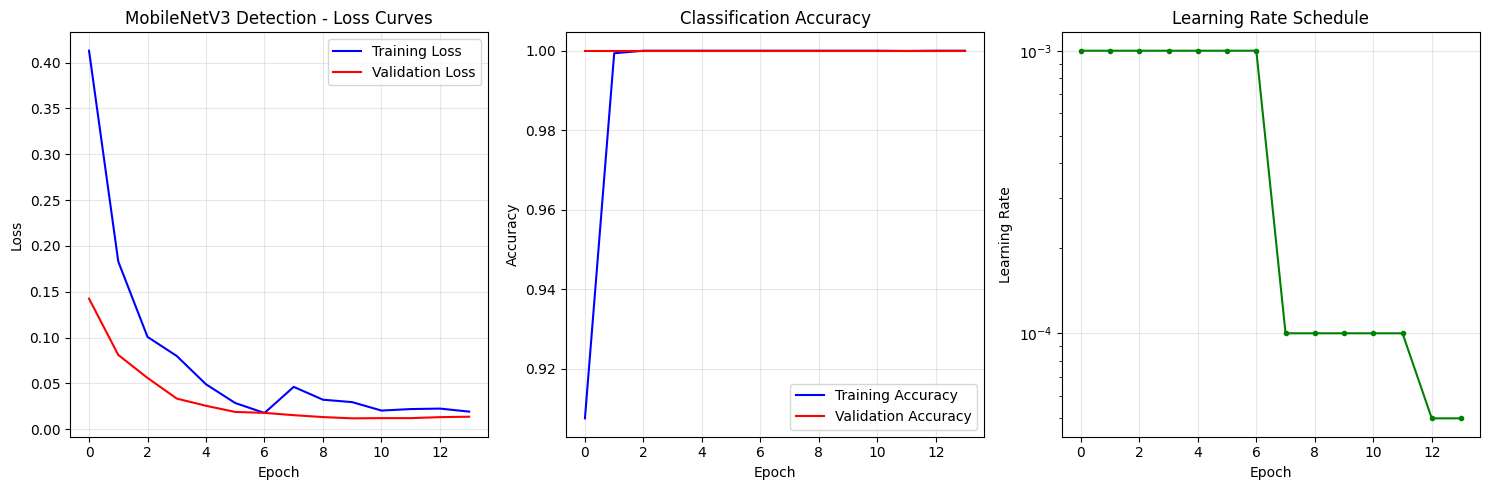


Kaggle Training Summary:
   Final Training Loss: 0.0192
   Final Validation Loss: 0.0136
   Final Training Accuracy: 1.000
   Final Validation Accuracy: 1.000
   Training log saved: mobilenetv3_training_log.csv


In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Visualize training progress
if combined_history:
    print("Creating training visualizations...")
    
    plt.figure(figsize=(15, 5))
    
    # Loss curves
    plt.subplot(1, 3, 1)
    plt.plot(combined_history['loss'], label='Training Loss', color='blue')
    plt.plot(combined_history['val_loss'], label='Validation Loss', color='red')
    plt.title('MobileNetV3 Detection - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Classification accuracy
    plt.subplot(1, 3, 2)
    plt.plot(combined_history['classification_output_accuracy'], label='Training Accuracy', color='blue')
    plt.plot(combined_history['val_classification_output_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Learning rate schedule
    plt.subplot(1, 3, 3)
    if hasattr(kaggle_logger, 'training_log'):
        lr_values = [log['lr'] for log in kaggle_logger.training_log]
        plt.plot(lr_values, color='green', marker='o', markersize=3)
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/mobilenetv3_training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Training summary
    final_train_loss = combined_history['loss'][-1]
    final_val_loss = combined_history['val_loss'][-1]
    final_train_acc = combined_history['classification_output_accuracy'][-1]
    final_val_acc = combined_history['val_classification_output_accuracy'][-1]
    
    print(f"\nKaggle Training Summary:")
    print(f"   Final Training Loss: {final_train_loss:.4f}")
    print(f"   Final Validation Loss: {final_val_loss:.4f}")
    print(f"   Final Training Accuracy: {final_train_acc:.3f}")
    print(f"   Final Validation Accuracy: {final_val_acc:.3f}")
    
    # Save training log
    if hasattr(kaggle_logger, 'training_log'):
        training_df = pd.DataFrame(kaggle_logger.training_log)
        training_df.to_csv('/kaggle/working/mobilenetv3_training_log.csv', index=False)
        print(f"   Training log saved: mobilenetv3_training_log.csv")
    
else:
    print("No training history to visualize")

## Model Testing & Evaluation

In [29]:
def test_mobilenetv3_detector(model, test_images, test_classifications, test_bboxes):
    """
    Test MobileNetV3 detector on validation data
    """
    
    if len(test_images) == 0:
        print("No test data available")
        return None
    
    print(f"Testing MobileNetV3 detector on {len(test_images)} samples...")
    
    # Get predictions
    predictions = model.predict(test_images, batch_size=16, verbose=1)
    pred_classifications, pred_bboxes = predictions
    
    # Classification metrics
    pred_classes_binary = (pred_classifications.flatten() > 0.5).astype(int)
    true_classes_binary = (test_classifications.flatten() > 0.5).astype(int)
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    class_accuracy = accuracy_score(true_classes_binary, pred_classes_binary)
    class_precision = precision_score(true_classes_binary, pred_classes_binary, zero_division=0)
    class_recall = recall_score(true_classes_binary, pred_classes_binary, zero_division=0)
    class_f1 = f1_score(true_classes_binary, pred_classes_binary, zero_division=0)
    
    # Bounding box metrics (only for positive samples)
    positive_indices = true_classes_binary == 1
    if np.sum(positive_indices) > 0:
        bbox_mae = np.mean(np.abs(pred_bboxes[positive_indices] - test_bboxes[positive_indices]))
        bbox_mse = np.mean(np.square(pred_bboxes[positive_indices] - test_bboxes[positive_indices]))
    else:
        bbox_mae = bbox_mse = 0.0
    
    results = {
        'classification_accuracy': class_accuracy,
        'classification_precision': class_precision,
        'classification_recall': class_recall,
        'classification_f1': class_f1,
        'bbox_mae': bbox_mae,
        'bbox_mse': bbox_mse,
        'num_samples': len(test_images),
        'num_positive': np.sum(positive_indices)
    }
    
    return results, predictions

# Test the model
if len(X_val) > 0 and 'model' in locals():
    test_results, val_predictions = test_mobilenetv3_detector(
        model, X_val, y_val_class, y_val_bbox
    )
    
    if test_results:
        print("\nKaggle Model Test Results:")
        print(f"   Classification Accuracy: {test_results['classification_accuracy']:.3f}")
        print(f"   Classification Precision: {test_results['classification_precision']:.3f}")
        print(f"   Classification Recall: {test_results['classification_recall']:.3f}")
        print(f"   Classification F1-Score: {test_results['classification_f1']:.3f}")
        print(f"   Bounding Box MAE: {test_results['bbox_mae']:.4f}")
        print(f"   Bounding Box MSE: {test_results['bbox_mse']:.4f}")
        print(f"   Test Samples: {test_results['num_samples']}")
        print(f"   Positive Samples: {test_results['num_positive']}")
        
else:
    print("No validation data for testing")
    test_results = None
    val_predictions = None

Testing MobileNetV3 detector on 200 samples...
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step

Kaggle Model Test Results:
   Classification Accuracy: 1.000
   Classification Precision: 1.000
   Classification Recall: 1.000
   Classification F1-Score: 1.000
   Bounding Box MAE: 0.0640
   Bounding Box MSE: 0.0062
   Test Samples: 200
   Positive Samples: 200


## Visual Prediction Examples

Creating prediction visualizations...


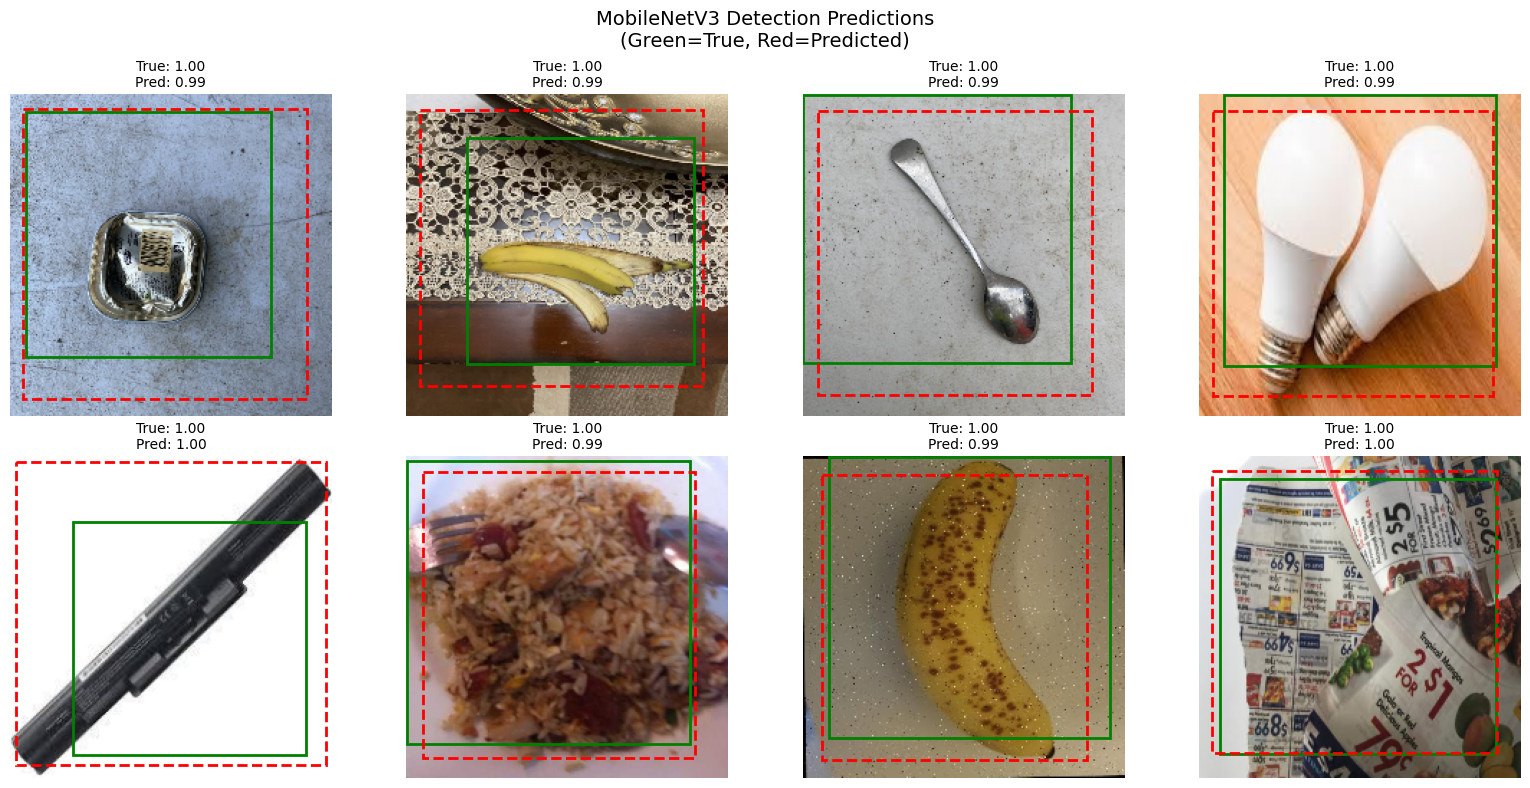

In [30]:
# Visualize predictions
if val_predictions is not None and len(X_val) > 0:
    print("Creating prediction visualizations...")
    
    pred_classifications, pred_bboxes = val_predictions
    
    # Select samples for visualization
    num_samples = min(8, len(X_val))
    sample_indices = np.random.choice(len(X_val), num_samples, replace=False)
    
    plt.figure(figsize=(16, 8))
    
    for i, idx in enumerate(sample_indices):
        plt.subplot(2, 4, i + 1)
        
        # Get image and predictions
        image = X_val[idx]
        true_class = y_val_class[idx]
        true_bbox = y_val_bbox[idx]
        pred_class = pred_classifications[idx][0]
        pred_bbox = pred_bboxes[idx]
        
        # Display image
        plt.imshow(image)
        
        # Draw true bounding box (green)
        if true_class > 0.5:
            y1, x1, y2, x2 = true_bbox
            h, w = image.shape[:2]
            rect_true = plt.Rectangle(
                (x1 * w, y1 * h), (x2 - x1) * w, (y2 - y1) * h,
                linewidth=2, edgecolor='green', facecolor='none', label='True'
            )
            plt.gca().add_patch(rect_true)
        
        # Draw predicted bounding box (red)
        if pred_class > 0.5:
            y1, x1, y2, x2 = pred_bbox
            h, w = image.shape[:2]
            rect_pred = plt.Rectangle(
                (x1 * w, y1 * h), (x2 - x1) * w, (y2 - y1) * h,
                linewidth=2, edgecolor='red', facecolor='none', linestyle='--', label='Pred'
            )
            plt.gca().add_patch(rect_pred)
        
        plt.title(f'True: {true_class:.2f}\nPred: {pred_class:.2f}', fontsize=10)
        plt.axis('off')
    
    plt.suptitle('MobileNetV3 Detection Predictions\n(Green=True, Red=Predicted)', fontsize=14)
    plt.tight_layout()
    plt.savefig('/kaggle/working/mobilenetv3_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
else:
    print("No predictions to visualize")

## TensorFlow.js Conversion Preparation

In [34]:
# Prepare model for TensorFlow.js conversion
if 'model' in locals():
    print("Preparing model for TensorFlow.js conversion...")
    
    # Save final model in SavedModel format (best for TF.js conversion)
    savedmodel_path = '/kaggle/working/mobilenetv3_detector_savedmodel'
    model.export(savedmodel_path)  # Use export() for SavedModel format
    print(f"   SavedModel exported: {savedmodel_path}")
    
    # Also save as H5 (backup format)
    h5_path = '/kaggle/working/mobilenetv3_detector_final.h5'
    model.save(h5_path)
    print(f"   H5 model saved: {h5_path}")
    
    # Also save in native Keras format (recommended)
    keras_path = '/kaggle/working/mobilenetv3_detector_final.keras'
    model.save(keras_path)
    print(f"   Keras model saved: {keras_path}")
    
    # Create conversion instructions
    conversion_instructions = f"""
# TensorFlow.js Conversion Instructions for MobileNetV3 Detector

## Method 1: From SavedModel (Recommended)
```bash
tensorflowjs_converter \\
    --input_format=tf_saved_model \\
    --output_format=tfjs_graph_model \\
    --signature_name=serving_default \\
    --saved_model_tags=serve \\
    {savedmodel_path} \\
    ./mobilenetv3_detector_tfjs
```

## Method 2: From H5 Model
```bash
tensorflowjs_converter \\
    --input_format=keras \\
    --output_format=tfjs_graph_model \\
    {h5_path} \\
    ./mobilenetv3_detector_tfjs
```

## Method 3: From Keras Model (Recommended for TF 2.x)
```bash
tensorflowjs_converter \\
    --input_format=keras \\
    --output_format=tfjs_graph_model \\
    {keras_path} \\
    ./mobilenetv3_detector_tfjs
```

## Web Implementation Example
```javascript
// Load MobileNetV3 detector
const detectorModel = await tf.loadGraphModel('./mobilenetv3_detector_tfjs/model.json');

// Preprocess image
const tensor = tf.browser.fromPixels(imageElement)
    .resizeNearestNeighbor([224, 224])
    .expandDims(0)
    .div(255.0);

// Get predictions
const predictions = await detectorModel.predict(tensor);
const [classification, bbox] = predictions;

// Process results
const hasWaste = classification.dataSync()[0] > 0.5;
const boundingBox = bbox.dataSync(); // [y_min, x_min, y_max, x_max]
```

## Model Info
- Input Shape: [1, 224, 224, 3]
- Output 1 (Classification): [1, 1] - Waste probability
- Output 2 (BBox): [1, 4] - Normalized coordinates [y_min, x_min, y_max, x_max]
- Architecture: MobileNetV3Large + Detection heads
- Framework: TensorFlow 2.x / Keras 3.x

## Format Comparison
- **SavedModel**: Best for TensorFlow Serving and cross-platform deployment
- **H5**: Legacy format, widely supported but may have compatibility issues
- **Keras (.keras)**: Native format for TensorFlow 2.x, recommended for new projects
"""
    
    with open('/kaggle/working/tensorflowjs_conversion_guide.md', 'w') as f:
        f.write(conversion_instructions)
    
    print(f"   Conversion guide saved: tensorflowjs_conversion_guide.md")
    print(f"   Model saved in 3 formats: SavedModel, H5, and native Keras")
    
else:
    print("No trained model available for conversion")

Preparing model for TensorFlow.js conversion...
Saved artifact at '/kaggle/working/mobilenetv3_detector_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_428')
Output Type:
  List[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)]
Captures:
  135395091981200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135398547495568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135398547496528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135398547497488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135398547498832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135398547494608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135398546313424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135398546316112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1353985

## Kaggle Output Packaging

In [37]:
# Package all outputs for Kaggle download
import zipfile
import json
import numpy as np
from datetime import datetime

print("Packaging Kaggle outputs...")

# Helper function to convert numpy types to JSON serializable types
def convert_numpy_types(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    if isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

# Create comprehensive training report
training_report = {
    'model_info': {
        'architecture': 'MobileNetV3Large + Detection Heads',
        'input_size': CONFIG['image_size'] if 'CONFIG' in locals() else [224, 224],
        'backbone': CONFIG['backbone'] if 'CONFIG' in locals() else 'MobileNetV3Large',
        'num_classes': CONFIG['num_classes'] if 'CONFIG' in locals() else 1,
        'class_names': CONFIG['class_names'] if 'CONFIG' in locals() else ['waste']
    },
    'training_config': convert_numpy_types(CONFIG) if 'CONFIG' in locals() else {},
    'training_results': convert_numpy_types(test_results) if test_results else {},
    'training_timestamp': datetime.now().isoformat(),
    'kaggle_environment': {
        'gpu_available': GPU_AVAILABLE if 'GPU_AVAILABLE' in locals() else False,
        'tpu_available': TPU_AVAILABLE if 'TPU_AVAILABLE' in locals() else False,
        'strategy': str(strategy) if 'strategy' in locals() else 'DefaultStrategy'
    }
}

# Save training report
with open('/kaggle/working/mobilenetv3_training_report.json', 'w') as f:
    json.dump(training_report, f, indent=2)

print("   Training report saved: mobilenetv3_training_report.json")

# Create ZIP package
zip_path = '/kaggle/working/06-MobileNetV3-Detection-Training-Results.zip'

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    
    # Add all result files
    files_to_zip = [
        '/kaggle/working/mobilenetv3_training_report.json',
        '/kaggle/working/tensorflowjs_conversion_guide.md'
    ]
    
    # Add model files if they exist
    model_files = [
        '/kaggle/working/best_mobilenetv3_detector.h5',
        '/kaggle/working/mobilenetv3_detector_final.h5',
        '/kaggle/working/mobilenetv3_detector_final.keras'
    ]
    
    for model_file in model_files:
        if os.path.exists(model_file):
            files_to_zip.append(model_file)
    
    # Add visualization files
    viz_files = [
        '/kaggle/working/mobilenetv3_training_curves.png',
        '/kaggle/working/mobilenetv3_predictions.png',
        '/kaggle/working/mobilenetv3_training_log.csv'
    ]
    
    # Add all existing files to ZIP
    for file_path in files_to_zip + viz_files:
        if os.path.exists(file_path):
            zipf.write(file_path, os.path.basename(file_path))
            print(f"   Added: {os.path.basename(file_path)}")
    
    # Add SavedModel directory if it exists
    savedmodel_dir = '/kaggle/working/mobilenetv3_detector_savedmodel'
    if os.path.exists(savedmodel_dir):
        print("   Adding SavedModel directory...")
        for root, dirs, files in os.walk(savedmodel_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arc_path = os.path.relpath(file_path, '/kaggle/working')
                zipf.write(file_path, arc_path)

print(f"\n=== KAGGLE TRAINING COMPLETED ===")
print(f"Results packaged: {zip_path}")

# Calculate package size safely
try:
    package_size_mb = os.path.getsize(zip_path) / (1024*1024)
    print(f"Package size: {package_size_mb:.1f} MB")
except FileNotFoundError:
    print("Package size: Unable to calculate (file not found)")

# Display final summary
print(f"\nKaggle Training Summary:")
print(f"   Model: MobileNetV3Large Object Detector")
print(f"   Training samples: {len(X_train) if 'X_train' in locals() else 'N/A'}")
print(f"   Validation samples: {len(X_val) if 'X_val' in locals() else 'N/A'}")

if test_results:
    print(f"   Final accuracy: {test_results['classification_accuracy']:.3f}")
    print(f"   Final precision: {test_results['classification_precision']:.3f}")
    print(f"   Final recall: {test_results['classification_recall']:.3f}")
    print(f"   Final F1-score: {test_results['classification_f1']:.3f}")
    print(f"   BBox MAE: {test_results['bbox_mae']:.4f}")
else:
    print("   No test results available")

print(f"   Ready for TensorFlow.js conversion")
print(f"   Compatible with your CNN-SVM pipeline")

print(f"\nNext Steps:")
print(f"   1. Download: {os.path.basename(zip_path)}")
print(f"   2. Convert to TensorFlow.js using the provided guide")
print(f"   3. Integrate with your Two-Stage Pipeline")
print(f"   4. Deploy for real-time waste detection")

print(f"\nFiles included in package:")
print(f"   ✅ Training report (JSON)")
print(f"   ✅ TensorFlow.js conversion guide")
print(f"   ✅ Model files (H5, Keras, SavedModel)")
print(f"   ✅ Training visualizations")
print(f"   ✅ All generated outputs")

Packaging Kaggle outputs...
   Training report saved: mobilenetv3_training_report.json
   Added: mobilenetv3_training_report.json
   Added: tensorflowjs_conversion_guide.md
   Added: best_mobilenetv3_detector.h5
   Added: mobilenetv3_detector_final.h5
   Added: mobilenetv3_detector_final.keras
   Added: mobilenetv3_training_curves.png
   Added: mobilenetv3_predictions.png
   Added: mobilenetv3_training_log.csv
   Adding SavedModel directory...

=== KAGGLE TRAINING COMPLETED ===
Results packaged: /kaggle/working/06-MobileNetV3-Detection-Training-Results.zip
Package size: 142.1 MB

Kaggle Training Summary:
   Model: MobileNetV3Large Object Detector
   Training samples: 800
   Validation samples: 200
   Final accuracy: 1.000
   Final precision: 1.000
   Final recall: 1.000
   Final F1-score: 1.000
   BBox MAE: 0.0640
   Ready for TensorFlow.js conversion
   Compatible with your CNN-SVM pipeline

Next Steps:
   1. Download: 06-MobileNetV3-Detection-Training-Results.zip
   2. Convert to Ten